# Workshop5: Data Warehouse  
วัตถุประสงค์ ศึกษาData warehouse โดยการย้ายไฟล์จาก`Workshop4` ไปยังData warehouse (**BigQuery**)

## Option 1*** เราใช้วิธีนี้  
ใช้ `BashOperation`ด้วยคำสั่ง bq loadโดย bq command เป็น command-line tool ที่สามารถใช้จัดการกับ BigQuery ได้ดูเพิ่มเติมได้ที่นี่ https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table  

 -------------
 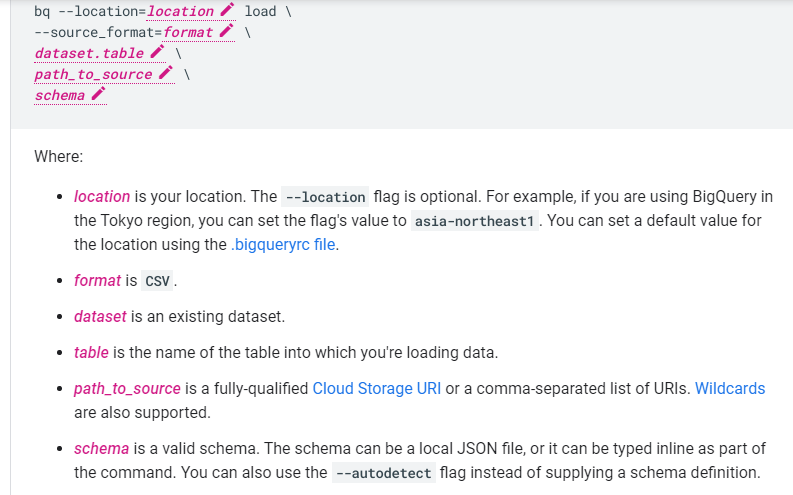

In [ ]:
# อย่าลืม import
from airflow.operators.bash import BashOperator

with DAG(
    "workshop5_bq_load_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["workshop"]
) as dag:

    dag.doc_md = """
    # Workshop5: Load to BigQuery ด้วยคำสั่ง bq load
    bq command เป็น command-line tool ที่สามารถใช้จัดการกับ BigQuery ได้
    ดูเพิ่มเติมได้ที่นี่ https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table
    """

    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )

    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )

    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )

    # TODO: สร้าง t4 ที่เป็น BashOperator เพื่อใช้งานกับ BigQuery และใส่ dependencies
    # เราจะโหลดข้อมูล Output.csv ไป workshop5.audible_data ที่อยู่ในBiqQuery
    t4 = BashOperator(
        task_id = "big_query_load",
        bash_command="bq load \
            --source_format=CSV --autodetect \
            workshop5.audible_data \
            gs://us-central1-demo-35ddcb16-bucket/data/output.csv",

    )

    [t1, t2] >> t3 >> t4

In [ ]:
# อีกแบบนึง แบบใช้SQLalchemy ซึ่งPandas support

from airflow.models import DAG
from airflow.operators.bash import BashOperator
from airflow.operators.python import PythonOperator
from airflow.providers.mysql.hooks.mysql import MySqlHook
from airflow.utils.dates import days_ago

import pandas as pd
import requests

from sqlalchemy import create_engine

MYSQL_CONNECTION = "mysql_default"   # ชื่อของ connection ใน Airflow ที่เซ็ตเอาไว้
CONVERSION_RATE_URL = "https://r2de2-workshop-vmftiryt6q-ts.a.run.app/usd_thb_conversion_rate"

# path ที่จะใช้
mysql_output_path = "/home/airflow/gcs/data/audible_data_merged.csv"
conversion_rate_output_path = "/home/airflow/gcs/data/conversion_rate.csv"
final_output_path = "/home/airflow/gcs/data/output.csv"


def get_data_from_mysql(transaction_path):
    # รับ transaction_path มาจาก task ที่เรียกใช้

    mysqlserver = MySqlHook(MYSQL_CONNECTION)   # เรียกใช้ MySqlHook เพื่อต่อไปยัง MySQL จาก connection ที่สร้างไว้ใน Airflow
    mysql_connection = mysqlserver.get_sqlalchemy_engine()
    with mysql_connection.begin() as mysqlH:
        audible_data = pd.read_sql(sql="SELECT * FROM audible_data", con=mysqlH)
        audible_transaction = pd.read_sql(sql="SELECT * FROM audible_transaction", con=mysqlH)

    # Merge data จาก 2 DataFrame เหมือนใน workshop1
    df = audible_transaction.merge(audible_data, how="left", left_on="book_id", right_on="Book_ID")

    # Save ไฟล์ CSV ไปที่ transaction_path ("/home/airflow/gcs/data/audible_data_merged.csv")
    # จะไปอยู่ที่ GCS โดยอัตโนมัติ
    df.to_csv(transaction_path, index=False)
    print(f"Output to {transaction_path}")

def get_conversion_rate(conversion_rate_path):
    r = requests.get(CONVERSION_RATE_URL)
    result_conversion_rate = r.json()
    df = pd.DataFrame(result_conversion_rate)

    # เปลี่ยนจาก index ที่เป็น date ให้เป็น column ชื่อ date แทน แล้วเซฟไฟล์ CSV
    df = df.reset_index().rename(columns={"index": "date"})
    df.to_csv(conversion_rate_path, index=False)
    print(f"Output to {conversion_rate_path}")


def merge_data(transaction_path, conversion_rate_path, output_path):
    # อ่านจากไฟล์ สังเกตว่าใช้ path จากที่รับ parameter มา
    transaction = pd.read_csv(transaction_path)
    conversion_rate = pd.read_csv(conversion_rate_path)

    transaction['date'] = transaction['timestamp']
    transaction['date'] = pd.to_datetime(transaction['date']).dt.date
    conversion_rate['date'] = pd.to_datetime(conversion_rate['date']).dt.date

    # merge 2 DataFrame
    final_df = transaction.merge(conversion_rate, how="left", left_on="date", right_on="date")

    # แปลงราคา โดยเอาเครื่องหมาย $ ออก และแปลงให้เป็น float
    final_df["Price"] = final_df.apply(lambda x: x["Price"].replace("$",""), axis=1)
    final_df["Price"] = final_df["Price"].astype(float)

    final_df["THBPrice"] = final_df["Price"] * final_df["conversion_rate"]
    final_df = final_df.drop(["date", "book_id"], axis=1)

    # save ไฟล์ CSV
    final_df.to_csv(output_path, index=False)
    print(f"Output to {output_path}")
    print("== End of Workshop 4 ʕ•́ᴥ•̀ʔっ♡ ==")


with DAG(
    "workshop5_bq_load_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["workshop"]
) as dag:

    dag.doc_md = """
    # Workshop5: Load to BigQuery ด้วยคำสั่ง bq load
    bq command เป็น command-line tool ที่สามารถใช้จัดการกับ BigQuery ได้
    ดูเพิ่มเติมได้ที่นี่ https://cloud.google.com/bigquery/docs/loading-data-cloud-storage-csv#loading_csv_data_into_a_table
    """

    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )

    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )

    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )

    # TODO: สร้าง t4 ที่เป็น BashOperator เพื่อใช้งานกับ BigQuery และใส่ dependencies
    t4 = BashOperator(
        task_id = "big_query_load",
        bash_command="bq load \
            --source_format=CSV --autodetect \
            workshop5.audible_data \
            gs://us-central1-demo-35ddcb16-bucket/data/output.csv",

    )

    [t1, t2] >> t3 >> t4


### Output  
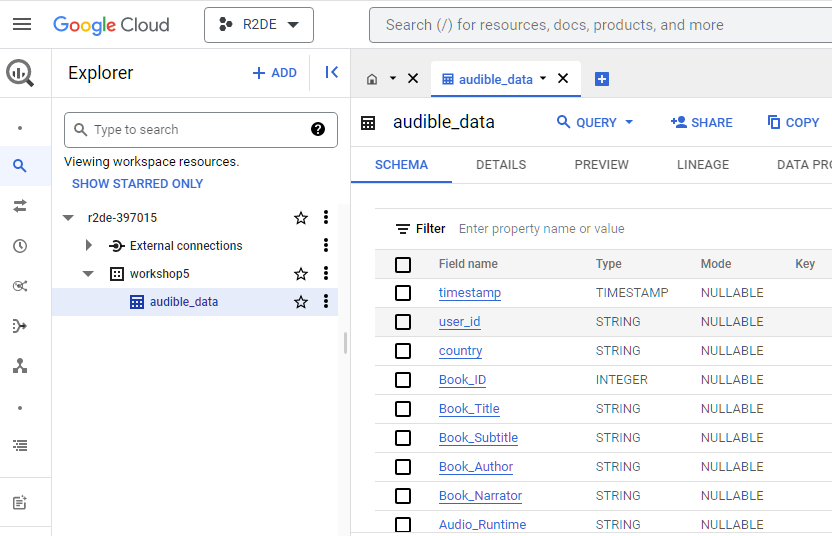

### Task dependencies  
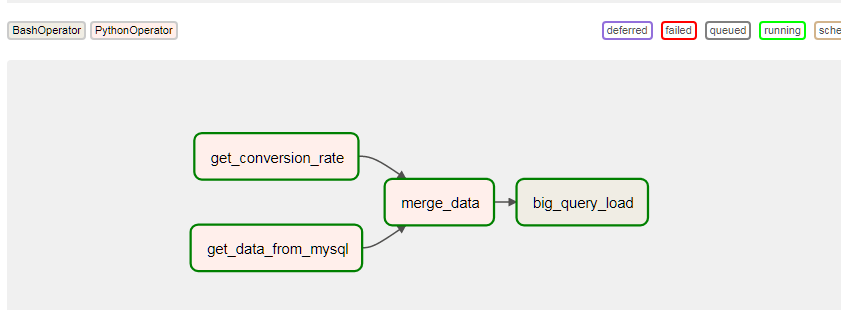

## Option 2  
ใช้ `GCSToBigQueryOperator` ของ Airflow เหมาะสำหรับ worker ที่ไม่มี bq command

In [ ]:
# อย่าลืม import GCSToBigQueryOperator
from airflow.providers.google.cloud.transfers.gcs_to_bigquery import GCSToBigQueryOperator

# ส่วน DAG และ Task จะมีการสร้างschema_fields
with DAG(
    "workshop5_gcs_to_bq_dag",
    start_date=days_ago(1),
    schedule_interval="@once",
    tags=["workshop"]
) as dag:

    dag.doc_md = """
    # Workshop5: Load to BigQuery ด้วยคำสั่ง GCSToBigQueryOperator ของ Airflow
    เหมาะสำหรับ worker ที่ไม่มี bq command
    Documentation : https://airflow.apache.org/docs/apache-airflow-providers-google/stable/operators/cloud/gcs.html
    Example: https://airflow.apache.org/docs/apache-airflow-providers-google/stable/_modules/airflow/providers/google/cloud/example_dags/example_gcs_to_bigquery.html
    """

    t1 = PythonOperator(
        task_id="get_data_from_mysql",
        python_callable=get_data_from_mysql,
        op_kwargs={"transaction_path": mysql_output_path},
    )

    t2 = PythonOperator(
        task_id="get_conversion_rate",
        python_callable=get_conversion_rate,
        op_kwargs={"conversion_rate_path": conversion_rate_output_path},
    )

    t3 = PythonOperator(
        task_id="merge_data",
        python_callable=merge_data,
        op_kwargs={
            "transaction_path": mysql_output_path,
            "conversion_rate_path": conversion_rate_output_path,
            "output_path": final_output_path
        },
    )
    # TODO: สร้าง t4 ที่เป็น GCSToBigQueryOperator เพื่อใช้งานกับ BigQuery แบบ Airflow และใส่ dependencies
    t4 =  GCSToBigQueryOperator(
    task_id='gcs_to_bq_example',
    bucket='asia-east2-workshop5-1cfc0401-bucket', #pathทีอยู่ของไฟล์
    source_objects=['data/output.csv'],
    destination_project_dataset_table='workshop5.audible_data2',
    schema_fields=[
            {
                "mode": "NULLABLE",
                "name": "timestamp",
                "type": "TIMESTAMP"
            },
            {
                "mode": "NULLABLE",
                "name": "user_id",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "country",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_ID",
                "type": "INTEGER"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Title",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Subtitle",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Author",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Book_Narrator",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audio_Runtime",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Audiobook_Type",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Categories",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Rating",
                "type": "STRING"
            },
            {
                "mode": "NULLABLE",
                "name": "Total_No__of_Ratings",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "Price",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "conversion_rate",
                "type": "FLOAT"
            },
            {
                "mode": "NULLABLE",
                "name": "THBPrice",
                "type": "FLOAT"
            }
        ],
        write_disposition='WRITE_TRUNCATE',
    )

    # write_truencate ==> สร้าง table ใหม่
    # write_append ==> เพิ่มเทเบิ้ลเดิม



    [t1, t2] >> t3 >> t4

--------------------------------
# จบ Workshop 5